<a href="https://colab.research.google.com/github/hannape/CNN-pierwsze-podejscie/blob/master/wavenet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import librosa
import matplotlib.pyplot as plt
import librosa.display
from keras.preprocessing.image import ImageDataGenerator
import glob
import os
import random

In [0]:
## Keras Implementation of Deepmind's WaveNet for Supervised Learning Tasks, https://github.com/mjpyeon/wavenet-classifier

import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Activation, Dropout, Add, TimeDistributed, Multiply, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import History, ModelCheckpoint


class WaveNetClassifier():
  def __init__(self, input_shape, output_shape, kernel_size = 2, dilation_depth = 9, n_filters = 40, task = 'classification', regression_range = None, load=False, load_dir='./'):
    """
    Parameters:
      input_shape: (tuple) tuple of input shape. (e.g. If input is 6s raw waveform with sampling rate = 16kHz, (96000,) is the input_shape)
      output_shape: (tuple)tuple of output shape. (e.g. If we want classify the signal into 100 classes, (100,) is the output_shape)
      kernel_size: (integer) kernel size of convolution operations in residual blocks
      dilation_depth: (integer) type total depth of residual blocks
      n_filters: (integer) # of filters of convolution operations in residual blocks
      task: (string) 'classification' or 'regression'
      regression_range: (list or tuple) target range of regression task
      load: (bool) load previous WaveNetClassifier or not
      load_dir: (string) the directory where the previous model exists
    """      
    # save task info
    if task == 'regression':
      if regression_range[0] == 0:
        self.activation = 'sigmoid'
        self.scale_ratio = regression_range[1]
      elif regression_range[0] == - regression_range[1]:
        self.activation = 'tanh'
        self.scale_ratio = regression_range[1]
      elif regression_range == None:
        self.activation = 'linear'
        self.scale_ratio = 1
      else:
        print('ERROR: wrong regression range')
        sys.exit()  
    elif task == 'classification':
      self.activation = 'softmax'
      self.scale_ratio = 1      
    else:
      print('ERROR: wrong task')
      sys.exit()
    
    # save input info
    if len(input_shape) == 1:
      self.expand_dims = True
    elif len(input_shape) == 2:
      self.expand_dims = False
    else:
      print('ERROR: wrong input shape')
      sys.exit()
    self.input_shape = input_shape
    
    # save output info
    if len(output_shape) == 1:
      self.time_distributed = False
    elif len(output_shape) == 2:
      self.time_distributed = True
    else:
      print('ERROR: wrong output shape')
      sys.exit()
    self.output_shape = output_shape
    
    # save hyperparameters of WaveNet
    self.kernel_size = kernel_size
    self.dilation_depth = dilation_depth
    self.n_filters = n_filters
    self.manual_loss = None

    
    if load is True:
      self.model = load_model(load_dir+"saved_wavenet_clasifier.h5", custom_objects={'tf':tf})
      self.prev_history = pd.read_csv(load_dir+'wavenet_classifier_training_history.csv')
      self.start_idx = len(self.prev_history)
      self.history = None
    else:
      self.model = self.construct_model()
      self.start_idx = 0
      self.history = None
      self.prev_history = None

    
  def residual_block(self, x, i):
    tanh_out = Conv1D(self.n_filters, 
                      self.kernel_size, 
                      dilation_rate = self.kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_tanh' % (self.kernel_size ** i), 
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(self.n_filters, 
                      self.kernel_size, 
                      dilation_rate = self.kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_sigm' % (self.kernel_size ** i), 
                      activation='sigmoid'
                      )(x)
    z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
    skip = Conv1D(self.n_filters, 1, name='skip_%d'%(i))(z)
    res = Add(name='residual_block_%d' % (i))([skip, x])
    return res, skip
  
  def construct_model(self):    
    x = Input(shape=self.input_shape, name='original_input')
    if self.expand_dims == True:
      x_reshaped = Reshape(self.input_shape + (1,), name='reshaped_input')(x)
    else:
      x_reshaped = x
    skip_connections = []
    out = Conv1D(self.n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x_reshaped)
    for i in range(1, self.dilation_depth + 1):
      out, skip = self.residual_block(out,i)
      skip_connections.append(skip)
    out = Add(name='skip_connections')(skip_connections)
    out = Activation('relu')(out)
    out = Conv1D(self.n_filters, 80, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(out)
    out = AveragePooling1D(80, padding='same', name='downsample_to_200Hz')(out)
    if self.time_distributed:
      target_kernel_size = (int) (self.input_shape[0] / 80 / self.output_shape[0]) # prev_len / x = target_len => x = prev_len / target_len
      out = Conv1D(self.n_filters, target_kernel_size, padding='same', name = 'conv_fit_to_target', activation='relu')(out)
      out = Conv1D(self.output_shape[1], target_kernel_size, padding='same', name='conv_final')(out)
      out = AveragePooling1D(target_kernel_size, padding='same')(out)
      out = TimeDistributed(Activation(self.activation))(out)
    else:
      out = Conv1D(self.n_filters, 100, padding='same', activation='relu', name='conv_500ms')(out)
      out = Conv1D(self.output_shape[0], 100, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
      out = AveragePooling1D(100, padding='same',name = 'downsample_to_2Hz')(out)
      out = Conv1D(self.output_shape[0], (int) (self.input_shape[0] / 8000), padding='same', name='final_conv')(out)
      out = AveragePooling1D((int) (self.input_shape[0] / 8000), name='final_pooling')(out)
      out = Reshape(self.output_shape)(out)
      out = Activation(self.activation)(out)
    if self.scale_ratio != 1:
      out = Lambda(lambda x: x * self.scale_ratio, name='output_reshaped')(out)
    model = Model(x, out)  
    model.summary()
    return model
    
  def get_model(self):
    return self.model
    
  def add_loss(self, loss):
    self.manual_loss = loss
  
  def fit(self, X, Y, validation_data = None, epochs = 100, batch_size = 32, optimizer='adam', save=False, save_dir='./'):
    # set default losses if not defined
    #if self.manual_loss is not None:
    #  loss = self.manual_loss
    #  metrics = None
    #else:
    #  if self.task == 'classification':
    loss = 'binary_crossentropy' #'categorical_crossentropy'
    metrics = ['accuracy']
    #  else:
    #    loss = 'mean_squared_error'
    #    metrics = None
        
    # set callback functions
    if save:
      saved = save_dir + "saved_wavenet_clasifier.h5"
      hist = save_dir + 'wavenet_classifier_training_history.csv'
      if validation_data is None:
        checkpointer = ModelCheckpoint(filepath=saved, monitor='loss', verbose=1, save_best_only=True)
      else:
        checkpointer = ModelCheckpoint(filepath=saved, monitor='val_loss', verbose=1, save_best_only=True)
      history = History()
      callbacks = [history, checkpointer]
    else:
      callbacks = None
      
    # compile the model
    self.model.compile(optimizer, loss, metrics)
    #try:
    self.history = self.model.fit(X, Y, shuffle = True, batch_size=batch_size, epochs = epochs, validation_data = validation_data, callbacks=callbacks, initial_epoch=self.start_idx)
    #except:
    #  if save:
    #  	df = pd.DataFrame.from_dict(history.history)
    #  	df.to_csv(hist, encoding='utf-8', index=False)
    #  raise
    #  sys.exit()
    return self.history


  def predict(self, x):
    return self.model.predict(x)


In [4]:
## creating exemplary dataset e.g from one 30min recording - 1800 

# Tworzenie macierzy treningowej / testowej z wavów na Google dysku

sample_rate = 44100

main_file_path =   "drive/My Drive/nagrania_probne/*/"  # główny folder z subfolderami "drive/My Drive/nagrania_probne/Test2016/*/"
nagranie = glob.glob(main_file_path)
print(nagranie)
np.size(nagranie)

['drive/My Drive/nagrania_probne/4szum_sredni_BUK4_20160918_013604_1s/', 'drive/My Drive/nagrania_probne/6wichura_deszcz_BUK4_20161005_022304_1s/', 'drive/My Drive/nagrania_probne/7wiatr_BUK4_20161006_002104_1s/', 'drive/My Drive/nagrania_probne/3wzgledna_cisza_BUK4_20160925_224604_1s/', 'drive/My Drive/nagrania_probne/9niski_szum_BUK4_20161025_000604_1s/', 'drive/My Drive/nagrania_probne/5szum_sredni_nakladki_BUK4_20161011_000804_1s/', 'drive/My Drive/nagrania_probne/1swierszcze_nakladki_BUK4_20160925_204604_1s/', 'drive/My Drive/nagrania_probne/BUK4_20161104_041504_1s/', 'drive/My Drive/nagrania_probne/BUK4_20161005_012304_1s/', 'drive/My Drive/nagrania_probne/BUK4_20161002_235805_1s/', 'drive/My Drive/nagrania_probne/BUK4_20161104_011504_1s/', 'drive/My Drive/nagrania_probne/BUK4_20161103_204504_1s/', 'drive/My Drive/nagrania_probne/BUK4_20161019_011904_1s/', 'drive/My Drive/nagrania_probne/BUK4_20160918_223304_1s/', 'drive/My Drive/nagrania_probne/BUK4_20160919_013304_1s/', 'drive/

17

In [0]:
for j in range (1,4):  # np.size(nagranie)

  print(nagranie[j])
  file_path = nagranie[j]+ "*.wav"                     #"drive/My Drive/nagrania_probne/1swierszcze_nakladki_BUK4_20160925_204604_1s/"
  print(file_path)
  n_files = glob.glob(file_path)    #'drive/My Drive/nagrania_probne/1swierszcze_nakladki_BUK4_20160925_204604_67.wav'
  sizes = [len(k) for k in n_files]
  name_cut = max(sizes)
  ##print(name_cut)
  
  file_path = sorted(glob.glob(file_path), key=lambda name: int(name[name_cut-8:-4]))    ##'drive/My Drive/nagrania_probne/1swierszcze_nakladki_BUK4_20160925_204604_67.wav'
  ##print(file_path)

  ##col, rows = 87, 60;
  col, rows = 1799, 1;
  n_train = 100 #np.size(file_path) #1799
  matrix_audio = n_train*[rows*[col*[0]]]
  ##matrix = n_train*[rows*[col*[0]]]

  for i in range (0,n_train):
    audio = librosa.core.load(file_path[i], sr=44100)[0]
    matrix_audio[i]=audio
    ##matrix[i] = librosa.feature.melspectrogram(y=audio, sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
    ##print(np.shape(mel_spec))
    
  ##print(np.shape(matrix))
  ##plt.imshow(matrix[i], cmap="jet")
  nazwa_nagr = nagranie[j][31:-3]
  print(nazwa_nagr)
  np.save(('drive/My Drive/all_train/wavy/'+ nazwa_nagr +'100' ),matrix_audio)
  print(np.shape(matrix_audio))

In [0]:
# TRAIN. stworzenie jednej macierzy z wszystkimi wavami treningowymi, + anotacje

file_path_wav= "drive/My Drive/all_train/wavy/*"   # główny folder z subfolderami "drive/My Drive/nagrania_probne/*/"
fold_train = sorted(glob.glob(file_path_wav))
print(fold_train)
#X_train = np.load('drive/My Drive/all_train/wavy/1swierszcze_nakladki_BUK4_20160925_204604_.npy')

file_path_wav_label= "drive/My Drive/labele/labele_train/*"   # główny folder z subfolderami "drive/My Drive/nagrania_probne/*/"
fold_label = sorted(glob.glob(file_path_wav_label))
print(fold_label)
#y_read = pd.read_csv('drive/My Drive/labele/labele_train/1swierszcze_nakladki_BUK4_20160925_204604_1s.csv')
#y_train = y_read.hasbird  ## [0:500] end?


In [9]:
X_train=np.array([])
y_train=np.array([])
for i in range (0,np.size(fold_train)):  #np.size(fold_train)
  nazwa_nagr = fold_train[i][30:]
  B = np.load('drive/My Drive/all_train/wavy/'+ nazwa_nagr)
  print(np.shape(B))
  X_train = np.vstack([X_train, B]) if X_train.size else B
  #X_train = np.concatenate((X_train,B))
  print(nazwa_nagr)
    
  nazwa_pliku = fold_train[i][30:-4]
  print(nazwa_pliku)
  ##nazwa_label = fold_label [i][35:]
  ##print(nazwa_label)
  B_df = pd.read_csv('drive/My Drive/labele/labele_train/'+ nazwa_pliku + '1s.csv')
  y_train= np.concatenate((y_train,B_df.hasbird))

print(np.shape(X_train))
print(np.size(y_train))

(1799, 44100)
1swierszcze_nakladki_BUK4_20160925_204604_.npy
1swierszcze_nakladki_BUK4_20160925_204604_
(1799, 44100)
5szum_sredni_nakladki_BUK4_20161011_000804_.npy
5szum_sredni_nakladki_BUK4_20161011_000804_
(3598, 44100)
3598


In [0]:
wnc = WaveNetClassifier((44100,), (1,), kernel_size = 2, dilation_depth = 9, n_filters = 40) #, task = 'classification'




In [49]:
##from WaveNetClassifier import WaveNetClassifier

wnc.fit(X_train, y_train, epochs = 3, batch_size = 32, optimizer='adam', save=True, save_dir='./')


Epoch 1/3
3598/3598 [==============================] - 469s 130ms/step - loss: 15.1891 - acc: 0.0472

Epoch 00001: loss improved from inf to 15.18913, saving model to ./saved_wavenet_clasifier.h5
Epoch 2/3
3598/3598 [==============================] - 463s 129ms/step - loss: 15.1891 - acc: 0.0472

Epoch 00002: loss did not improve from 15.18913
Epoch 3/3
3598/3598 [==============================] - 463s 129ms/step - loss: 15.1891 - acc: 0.0472

Epoch 00003: loss did not improve from 15.18913


In [55]:
## tworzenie testowych macierzy 
main_file_path =   "drive/My Drive/nagrania_probne/Test2016/*/"  # główny folder z subfolderami "drive/My Drive/nagrania_probne/Test2016/*/"
nagranie = glob.glob(main_file_path)
print(nagranie)
np.size(nagranie)

for j in range (0,1):  # np.size(nagranie)

  print(nagranie[j])
  nazwa_nagr = nagranie[j][40:-3]
  print(nazwa_nagr)
  file_path = nagranie[j]+ "*.wav"                     #"drive/My Drive/nagrania_probne/1swierszcze_nakladki_BUK4_20160925_204604_1s/"
  print(file_path)
  n_files = glob.glob(file_path)    #'drive/My Drive/nagrania_probne/1swierszcze_nakladki_BUK4_20160925_204604_67.wav'
  sizes = [len(k) for k in n_files]
  name_cut = max(sizes)  
  file_path = sorted(glob.glob(file_path), key=lambda name: int(name[name_cut-8:-4]))    ##'drive/My Drive/nagrania_probne/1swierszcze_nakladki_BUK4_20160925_204604_67.wav'

  col, rows = 1799, 1;
  n_train = np.size(file_path) #1799
  matrix_audio = n_train*[rows*[col*[0]]]

  for i in range (0,n_train):
    matrix_audio[i]=librosa.core.load(file_path[i], sr=44100)[0]

  np.save(('drive/My Drive/all_test/wavy/'+ nazwa_nagr),matrix_audio)
  print(np.shape(matrix_audio))

['drive/My Drive/nagrania_probne/Test2016/BUK4_20160922_005604_1s/', 'drive/My Drive/nagrania_probne/Test2016/BUK5_20161101_002104a_1s/', 'drive/My Drive/nagrania_probne/Test2016/BUK5_20161101_002104b_1s/', 'drive/My Drive/nagrania_probne/Test2016/BUK4_20161008_004605_1s/', 'drive/My Drive/nagrania_probne/Test2016/BUK4_20161016_035704_1s/', 'drive/My Drive/nagrania_probne/Test2016/BUK4_20161016_012704_1s/']
drive/My Drive/nagrania_probne/Test2016/BUK4_20160922_005604_1s/
BUK4_20160922_005604_
drive/My Drive/nagrania_probne/Test2016/BUK4_20160922_005604_1s/*.wav
(1799, 44100)


In [58]:
file_path_wav= "drive/My Drive/all_test/wavy/*"   # główny folder z subfolderami "drive/My Drive/nagrania_probne/*/"
fold_test = sorted(glob.glob(file_path_wav))
print(fold_test)
#X_train = np.load('drive/My Drive/all_train/wavy/1swierszcze_nakladki_BUK4_20160925_204604_.npy')

file_path_wav_label= "drive/My Drive/labele/labele_test/*"   # główny folder z subfolderami "drive/My Drive/nagrania_probne/*/"
fold_label = sorted(glob.glob(file_path_wav_label))
print(fold_label)

X_test=np.array([])
y_test=np.array([])
for i in range (0,np.size(fold_test)):  #np.size(fold_train)
  nazwa_nagr = fold_test[i][29:]
  B = np.load('drive/My Drive/all_test/wavy/'+ nazwa_nagr)
  print(np.shape(B))
  X_test = np.vstack([X_test, B]) if X_test.size else B
  #X_train = np.concatenate((X_train,B))
  print(nazwa_nagr)
    
  nazwa_pliku = fold_test[i][29:-4]
  print(nazwa_pliku)
  ##nazwa_label = fold_label [i][35:]
  ##print(nazwa_label)
  B_df = pd.read_csv('drive/My Drive/labele/labele_test/'+ nazwa_pliku + '1s.csv')
  y_test= np.concatenate((y_test,B_df.hasbird))

print(np.shape(X_test))
print(np.size(y_test))

['drive/My Drive/all_test/wavy/BUK4_20160922_005604_.npy']
['drive/My Drive/labele/labele_test/BUK4_20160922_005604_1s.csv', 'drive/My Drive/labele/labele_test/BUK4_20161008_004605_1s.csv', 'drive/My Drive/labele/labele_test/BUK4_20161016_012704_1s.csv', 'drive/My Drive/labele/labele_test/BUK4_20161016_035704_1s.csv', 'drive/My Drive/labele/labele_test/BUK5_20161101_002104a_1s.csv', 'drive/My Drive/labele/labele_test/BUK5_20161101_002104b_1s.csv']
(1799, 44100)
BUK4_20160922_005604_.npy
BUK4_20160922_005604_
(1799, 44100)
1799


In [0]:
y_pred = wnc.predict(X_test)

AUC: 0.500


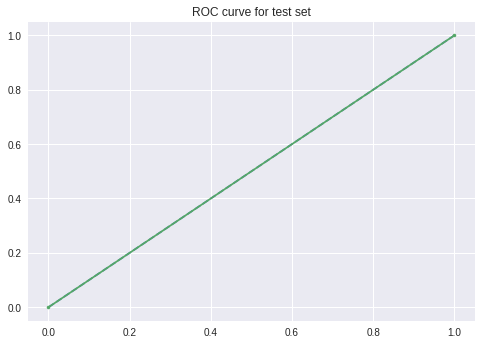

In [63]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC curve for test set')
pyplot.show()

In [64]:
print(y_test[0:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
